In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from keras.utils.vis_utils import plot_model
from PIL import Image
import os.path
import wget
import zipfile
import glob

In [3]:
def load_data():
    url = "https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip"
    file_name = wget.filename_from_url(url)
    if os.path.exists(file_name) == False:
        file_name = wget.download(url)
    with zipfile.ZipFile(file_name,"r") as zip_ref:
        zip_ref.extractall()

    pair_A = []
    pair_B = []
    for images in glob.glob("apple2orange/trainA/*"):
        pair_A.append(images)

    for images in glob.glob("apple2orange/trainB/*"):
        pair_B.append(images)

    pair_A_array = np.zeros(shape = (len(pair_A), 256, 256, 3))
    pair_B_array = np.zeros(shape = (len(pair_B), 256, 256, 3))

    for i in range(len(pair_A)):
        im = Image.open(pair_A[i])
        im2arr = np.array(im)
        im2arr = (im2arr - np.min(im2arr))/np.ptp(im2arr)
        pair_A_array[i] = im2arr

    for i in range(len(pair_B)):
        im = Image.open(pair_B[i])
        im2arr = np.array(im)
        im2arr = (im2arr - np.min(im2arr))/np.ptp(im2arr)
        pair_B_array[i] = im2arr
        
    pair_A_array = np.float32(pair_A_array)
    pair_B_array = np.float32(pair_B_array)
        
    return pair_A_array, pair_B_array

In [4]:
pair_A_array, pair_B_array = load_data()

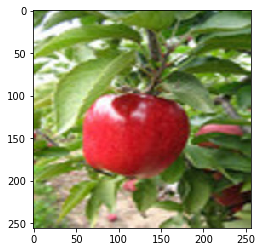

In [5]:
plt.imshow(pair_A_array[0])

In [6]:
def generative_model(img_shape, name):
    
    depth = 32
    k_size = 4
    generator_input = keras.Input(shape = img_shape, name = "Image_Input")
    conv1 = layers.Conv2D(depth, kernel_size = k_size, strides = 2,
                          padding = "same", name = "Conv_1")(
        generator_input)
    conv1 = layers.LeakyReLU(alpha = 0.2)(conv1)
    conv1 = layers.BatchNormalization(name = "Batch_Normalizing_1")(conv1)
    
    conv2 = layers.Conv2D(depth*2, kernel_size = k_size, strides = 2,
                          padding = "same", name = "Conv_2")(conv1)
    conv2 = layers.LeakyReLU(alpha = 0.2)(conv2)
    conv2 = layers.BatchNormalization(name = "Batch_Normalizing_2")(conv2)
    
    conv3 = layers.Conv2D(depth*4, kernel_size = k_size, strides = 2,
                          padding = "same", name = "Conv_3")(conv2)
    conv3 = layers.LeakyReLU(alpha = 0.2)(conv3)
    conv3 = layers.BatchNormalization(name = "Batch_Normalizing_3")(conv3)
    
    conv4 = layers.Conv2D(depth*8, kernel_size = k_size, strides = 2,
                          padding = "same", name = "Conv_4")(conv3)
    conv4 = layers.LeakyReLU(alpha = 0.2)(conv4)
    conv4 = layers.BatchNormalization(name = "Batch_Normalizing_4")(conv4)    
    
    conv5 = layers.UpSampling2D(size = 2)(conv4)
    conv5 = layers.Conv2D(depth*4, kernel_size = k_size, strides = 1,
                          padding = "same", name = "Conv_5")(conv5)
    conv5 = layers.LeakyReLU()(conv5)
    conv5 = layers.BatchNormalization(name = "Batch_Normalizing_5")(conv5)
    conv5 = layers.Concatenate()([conv5, conv3])

    conv6 = layers.UpSampling2D(size = 2)(conv5)
    conv6 = layers.Conv2D(depth*2, kernel_size = k_size, strides = 1,
                          padding = "same", name = "Conv_6")(conv6)
    conv6 = layers.LeakyReLU()(conv6)
    conv6 = layers.BatchNormalization(name = "Batch_Normalizing_6")(conv6)
    conv6 = layers.Concatenate()([conv6, conv2])
    
    conv7 = layers.UpSampling2D(size = 2)(conv6)
    conv7 = layers.Conv2D(depth, kernel_size = k_size, strides = 1,
                          padding = "same", name = "Conv_7")(conv7)
    conv7 = layers.LeakyReLU()(conv7)
    conv7 = layers.BatchNormalization(name = "Batch_Normalizing_7")(conv7)
    conv7 = layers.Concatenate()([conv7, conv1])    
    
    conv8 = layers.UpSampling2D(size = 2)(conv7)
    conv8 = layers.Conv2D(3, kernel_size = k_size, strides = 1, 
                          padding = "same", name = "Conv_8")(conv8)
    conv8 = layers.Activation("tanh")(conv8)
    
    
    return keras.Model(generator_input, conv8, name = name)

(256, 256, 3)


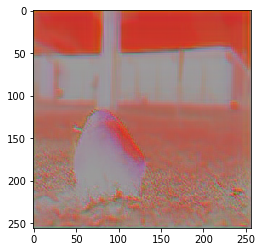

In [28]:
def test_generative_model():
    a = generative_model(pair_A_array[0].shape, "test_generator")
    x = a(pair_A_array[:2], training = False)
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        x = sess.run(x)
        x[0] = (x[0] - np.min(x[0]))/np.ptp(x[0])
        print(x[0].shape)
        imgplot = plt.imshow(x[0])
        plt.show()
test_generative_model()

In [9]:
def discriminative_model(img_shape, name):
    depth = 64
    dropout = 0.4
    k_size = 4
    
#     input_shape = input_image_shape #it should be 28*28*1
    discriminator_input = keras.Input(shape = img_shape, name = "Image_Input")
    x = layers.Conv2D(depth * 1, kernel_size = k_size, strides = 2, 
                      padding = "same", name = "Conv_1")(discriminator_input)
    x = layers.LeakyReLU(alpha=0.2, name = "LeakyRelu_Activation_1")(x)
#     x = layers.Dropout(dropout, name = "Inverse_Dropout_Regularizer_1")(x)

    x = layers.Conv2D(depth * 2, kernel_size = k_size, strides = 2, 
                      padding = "same", name = "Conv_2")(x)
    x = layers.LeakyReLU(alpha=0.2, name = "LeakyRelu_Activation_2")(x)
#     x = layers.Dropout(dropout, name = "Inverse_Dropout_Regularizer_2")(x)

    x = layers.Conv2D(depth * 4, kernel_size = k_size, strides = 2, 
                      padding = "same", name = "Conv_Layer_3")(x)
    x = layers.LeakyReLU(alpha=0.2, name = "LeakyRelu_Activation_3")(x)
#     x = layers.Dropout(dropout, name = "Inverse_Dropout_Regularizer_3")(x)

    x = layers.Conv2D(depth * 8, kernel_size = k_size, strides = 1, 
                      padding = "same", name = "Conv_Layer_4")(x)
    x = layers.LeakyReLU(alpha=0.2, name = "LeakyRelu_Activation_4")(x)
#     x = layers.Dropout(dropout, name = "Inverse_Dropout_Regularizer_4")(x)    

    discriminator_output = layers.Conv2D(1, kernel_size = k_size, 
                                         strides = 1, padding = "same", 
                                         name = "Conv_Layer_5")(x)

    return keras.Model(discriminator_input, discriminator_output, name = name)

In [10]:
def test_discriminative_model():
    a = generative_model(pair_A_array[0].shape, "test_generator")
    b = discriminative_model(pair_A_array[0].shape, "test_discriminator")
    x = a(pair_A_array[:2], training = False)
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        x = sess.run(x)
        x[0] = (x[0] - np.min(x[0]))/np.ptp(x[0])
        x = sess.run(b(x))
        print(x[0])

test_discriminative_model()

[[[-0.03144919]
  [-0.03717092]
  [-0.05465238]
  ...
  [-0.02335356]
  [-0.00284413]
  [-0.0080212 ]]

 [[-0.04627535]
  [-0.04178607]
  [-0.05767047]
  ...
  [-0.01080036]
  [ 0.00722513]
  [-0.00665616]]

 [[-0.05779317]
  [-0.03949572]
  [-0.03402352]
  ...
  [-0.01673942]
  [ 0.00052279]
  [-0.00122537]]

 ...

 [[-0.01645643]
  [ 0.00176098]
  [-0.00462683]
  ...
  [-0.0080245 ]
  [ 0.00998113]
  [ 0.00445538]]

 [[-0.01575611]
  [-0.00197838]
  [-0.00221177]
  ...
  [ 0.0021644 ]
  [ 0.01768733]
  [ 0.01981396]]

 [[-0.01140643]
  [-0.00181765]
  [ 0.00343329]
  ...
  [-0.01291051]
  [-0.00098765]
  [ 0.00343275]]]


In [11]:
def building_discriminators(img_shape):
    discriminator_A = discriminative_model(img_shape, "discriminator_A")
    discriminator_B = discriminative_model(img_shape, "discriminator_B")
    
    return discriminator_A, discriminator_B

def building_generators(img_A_shape, img_B_shape):
    generator_A2B = generative_model(img_A_shape, "generator_A2B")
    generator_B2A = generative_model(img_B_shape, "generator_B2A")
    
    return generator_A2B, generator_B2A

In [25]:
def attched_models(img_A_shape, img_B_shape):
    
    generator_A2B, generator_B2A = building_generators(img_A_shape, img_B_shape)
    discriminator_A, discriminator_B = building_discriminators(img_A_shape)
    
    img_A_input = keras.Input(shape = img_A_shape, name = "Input_Image")
    dis_A_from_A = discriminator_A(img_A_input)
    discriminator_A_from_A = keras.Model(img_A_input, dis_A_from_A,
                                         name = "dis_A_from_A")
    
    g_A2B = generator_A2B(img_A_input)
    dis_B_from_A = discriminator_B(g_A2B)
    discriminator_B_from_A = keras.Model(img_A_input, dis_B_from_A, 
                                         name = "dis_B_from_A")
    
    g_recons_B2A = generator_B2A(g_A2B)
    g_cycle_A2B2A = keras.Model(img_A_input, g_recons_B2A, 
                                name = "g_cycle_A2B2A")
    
    img_B_input = keras.Input(shape = img_B_shape, name = "Input_Image")
    dis_B_from_B = discriminator_B(img_B_input)
    discriminator_B_from_B = keras.Model(img_B_input, dis_B_from_B,
                                         name = "dis_B_from_B")
    
    g_B2A = generator_B2A(img_B_input)
    dis_A_from_B = discriminator_A(g_B2A)
    discriminator_A_from_B = keras.Model(img_B_input, dis_A_from_B,
                                         name = "dis_A_from_B")    
    
    g_recons_A2B = generator_A2B(g_B2A)
    g_cycle_B2A2B = keras.Model(img_B_input, g_recons_A2B, 
                                name = "g_cycle_B2A2B")
    
    optimizer = keras.optimizers.Adam(0.0002, 0.5)

    
    discriminator_A_from_A.compile(loss = "mse", 
                                   optimizer = optimizer, 
                                   metrics = ["accuracy"])
    
    discriminator_B_from_B.compile(loss = "mse", 
                                   optimizer = optimizer, 
                                   metrics = ["accuracy"])
    
    discriminator_B_from_A.compile(loss = "mse", 
                                   optimizer = optimizer, 
                                   metrics = ["accuracy"])
    
    discriminator_A_from_B.compile(loss = "mse", 
                                   optimizer = optimizer, 
                                   metrics = ["accuracy"])
    
    g_cycle_A2B2A.compile(loss = "mae", 
                          optimizer = optimizer, 
                          metrics = ["accuracy"])
    
    g_cycle_B2A2B.compile(loss = "mae", 
                          optimizer = optimizer, 
                          metrics = ["accuracy"])
    
    return (discriminator_A_from_A, discriminator_B_from_B, 
            discriminator_B_from_A, discriminator_A_from_B, 
            g_cycle_A2B2A, g_cycle_B2A2B, 
            generator_A2B, generator_B2A)

In [26]:
(discriminator_A_from_A, discriminator_B_from_B, 
 discriminator_B_from_A, discriminator_A_from_B, 
 g_cycle_A2B2A, g_cycle_B2A2B, 
 generator_A2B, generator_B2A) = attched_models(pair_A_array[0].shape, pair_B_array[0].shape)

## Discriminators Model Shape 

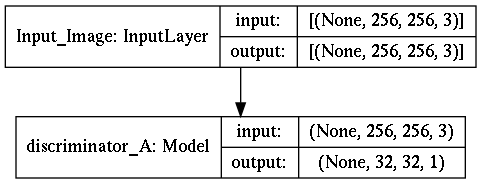

In [14]:
keras.utils.plot_model(discriminator_A_from_A, show_shapes=True)

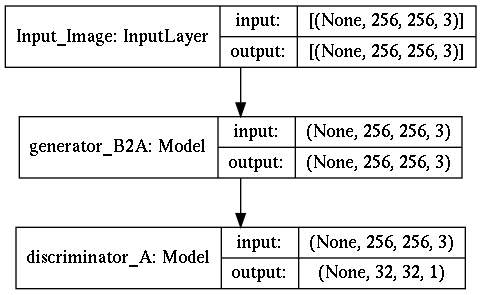

In [15]:
keras.utils.plot_model(discriminator_A_from_B, show_shapes=True)

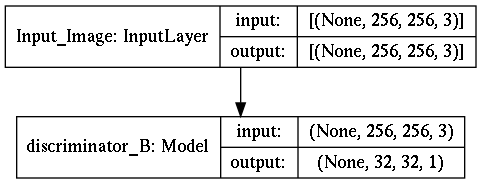

In [16]:
keras.utils.plot_model(discriminator_B_from_B, show_shapes=True)

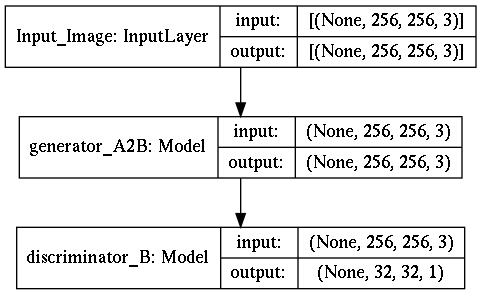

In [17]:
keras.utils.plot_model(discriminator_B_from_A, show_shapes=True)

## Generators Model Shape 

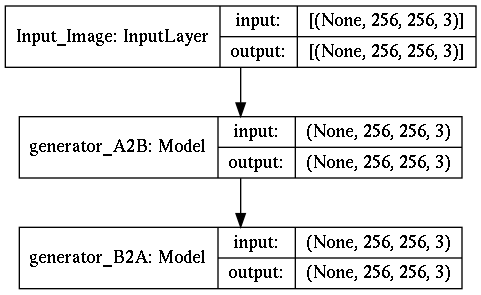

In [18]:
keras.utils.plot_model(g_cycle_A2B2A, show_shapes=True)

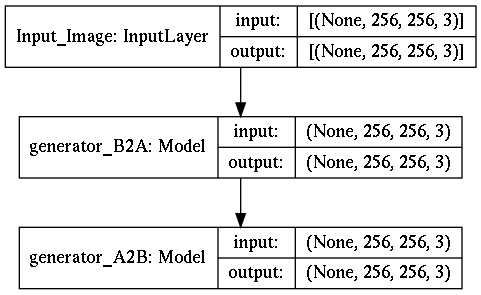

In [19]:
keras.utils.plot_model(g_cycle_B2A2B, show_shapes=True)

In [20]:
def batch_creator(pair_A_array, pair_B_array, batch_size):
    np.random.shuffle(pair_A_array)
    np.random.shuffle(pair_B_array)
    
    remaining = pair_A_array.shape[0] % batch_size
    splits = int(pair_A_array.shape[0] / batch_size)
    A_batch_remaining = pair_A_array[:remaining]
    A_batches = np.split(pair_A_array[remaining:], splits)
    A_batches.append(A_batch_remaining)
    
    remaining = pair_B_array.shape[0] % batch_size
    splits = int(pair_B_array.shape[0] / batch_size)
    B_batch_remaining = pair_B_array[:remaining]
    B_batches = np.split(pair_B_array[remaining:], splits)
    B_batches.append(B_batch_remaining)
    
    return A_batches, B_batches

we are at epoch:  0
	we are at batch number:  0
	[d_A_loss: 0.5471189022064209 ] [d_B_loss: 0.5204125046730042 ] [g_A_loss: 8.27053678035736 ] [g_B_loss: 8.087454855442047 ]
	we are at batch number:  1
	[d_A_loss: 1.0244172811508179 ] [d_B_loss: 0.808906614780426 ] [g_A_loss: 8.497190713882446 ] [g_B_loss: 8.613067865371704 ]
	we are at batch number:  2
	[d_A_loss: 0.33083200454711914 ] [d_B_loss: 0.29457899928092957 ] [g_A_loss: 7.312247633934021 ] [g_B_loss: 7.295922875404358 ]
	we are at batch number:  3
	[d_A_loss: 0.3001668453216553 ] [d_B_loss: 0.3687402307987213 ] [g_A_loss: 7.116849184036255 ] [g_B_loss: 7.083238124847412 ]


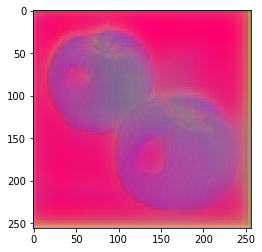

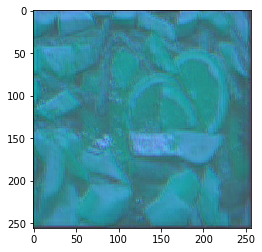

we are at epoch:  1
	we are at batch number:  0
	[d_A_loss: 0.2507786154747009 ] [d_B_loss: 0.24117620289325714 ] [g_A_loss: 6.803839981555939 ] [g_B_loss: 6.707594394683838 ]
	we are at batch number:  1
	[d_A_loss: 0.2555142343044281 ] [d_B_loss: 0.22181709110736847 ] [g_A_loss: 6.138667315244675 ] [g_B_loss: 6.122369468212128 ]
	we are at batch number:  2
	[d_A_loss: 0.22796933352947235 ] [d_B_loss: 0.2100280523300171 ] [g_A_loss: 5.956834137439728 ] [g_B_loss: 5.92633843421936 ]
	we are at batch number:  3
	[d_A_loss: 0.258694052696228 ] [d_B_loss: 0.19177792966365814 ] [g_A_loss: 6.041660517454147 ] [g_B_loss: 6.057399719953537 ]


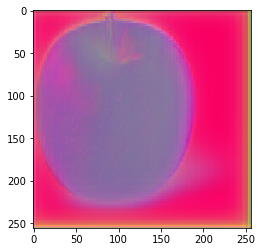

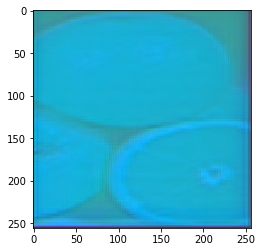

we are at epoch:  2
	we are at batch number:  0
	[d_A_loss: 0.21538257598876953 ] [d_B_loss: 0.23921442031860352 ] [g_A_loss: 5.91489714384079 ] [g_B_loss: 5.837262600660324 ]
	we are at batch number:  1
	[d_A_loss: 0.295748233795166 ] [d_B_loss: 0.20046323537826538 ] [g_A_loss: 5.593978226184845 ] [g_B_loss: 5.65623015165329 ]
	we are at batch number:  2


In [ ]:
(discriminator_A_from_A, discriminator_B_from_B, 
 discriminator_B_from_A, discriminator_A_from_B, 
 g_cycle_A2B2A, g_cycle_B2A2B, 
 generator_A2B, generator_B2A) = attched_models(pair_A_array[0].shape, pair_B_array[0].shape)

noise_dim = 1
epoch_num = 4000
batch_size = 256

d_loss_tracker = []
g_loss_tracker = []
d_acc_tracker = []
g_acc_tracker = []

for epoch in range(epoch_num):
    print("we are at epoch: ", epoch)
    
    img_A_batch, img_B_batch = batch_creator(pair_A_array, pair_B_array, batch_size)
    if len(img_A_batch) != len(img_B_batch):
        batch_num = min(len(img_A_batch), len(img_B_batch))
    else:
        batch_num = len(img_A_batch)
    
    for i_th_batch in range(batch_num):
        print("\twe are at batch number: ", i_th_batch)
        img_A = img_A_batch[i_th_batch]
        img_B = img_B_batch[i_th_batch]
        
        Y_label = np.ones([img_A.shape[0], 32, 32, 1])
        d_A_from_A_loss = discriminator_A_from_A.train_on_batch(img_A, Y_label)
        Y_label = np.ones([img_B.shape[0], 32, 32, 1])
        d_B_from_B_loss = discriminator_B_from_B.train_on_batch(img_B, Y_label)
        
        Y_label = np.zeros([img_A.shape[0], 32, 32, 1])
        d_B_from_A_loss = discriminator_B_from_A.train_on_batch(img_A, Y_label)
        Y_label = np.zeros([img_B.shape[0], 32, 32, 1])
        d_A_from_B_loss = discriminator_A_from_B.train_on_batch(img_B, Y_label)
        
        d_A_loss = (d_A_from_B_loss[0] + d_A_from_A_loss[0]) / 2
        d_A_acc = (d_A_from_B_loss[1] + d_A_from_A_loss[1]) / 2
    
        d_B_loss = (d_B_from_A_loss[0] + d_B_from_B_loss[0]) / 2
        d_B_acc = (d_B_from_A_loss[1] + d_B_from_B_loss[1]) / 2
        
        Y_label = np.ones([img_A.shape[0], 32, 32, 1])
        g_B_from_A_loss = discriminator_B_from_A.train_on_batch(img_A, Y_label)
        Y_label = np.ones([img_B.shape[0], 32, 32, 1])
        g_A_from_B_loss = discriminator_A_from_B.train_on_batch(img_B, Y_label)        
        
        g_A2B2A_loss = g_cycle_A2B2A.train_on_batch(img_A, img_A)
        g_B2A2B_loss = g_cycle_B2A2B.train_on_batch(img_B, img_B)
        
        cycle_loss = (g_A2B2A_loss[0] + g_B2A2B_loss[0]) / 2
        
        g_A_loss = g_A_from_B_loss[0] + (10 * cycle_loss)
        g_B_loss = g_B_from_A_loss[0] + (10 * cycle_loss)
        
        print("\t[d_A_loss:", d_A_loss, "] [d_B_loss:", d_B_loss, "] [g_A_loss:", 
              g_A_loss, "] [g_B_loss:", g_B_loss, "]")
        
    fake_A2B = generator_A2B.predict(pair_A_array[:2])
    fake_A2B[0] = (fake_A2B[0] - np.min(fake_A2B[0]))/np.ptp(fake_A2B[0])
    imgplot = plt.imshow(fake_A2B[0])    
    plt.show()
    fake_B2A = generator_B2A.predict(pair_B_array[:2])
    fake_B2A[0] = (fake_B2A[0] - np.min(fake_B2A[0]))/np.ptp(fake_B2A[0])
    imgplot = plt.imshow(fake_B2A[0])
    plt.show()
        

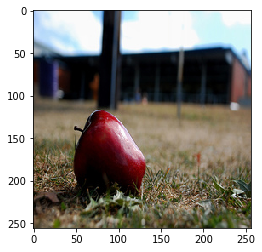

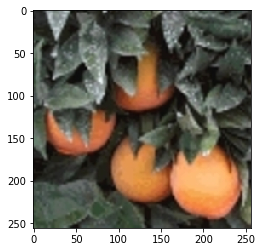

In [29]:
imgplot = plt.imshow(pair_A_array[0])
plt.show()
imgplot = plt.imshow(pair_B_array[0])
plt.show()